In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'oral-cancer-lips-and-tongue-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F908874%2F1541124%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T123124Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D18538cbcc09b5b2fc3285ff8ed7bcb433b1c149f461f23beaabf35271baa4e2b1f858e8f15e53f88520940851d9b79d70fdcdb483c67022b193da74cfb00050f9fd08ce775e4e9a9be464e31d30464304ffc84c96ccbb13be63ad574c8f3c42045228fe5bcc0f789ce0c2002cc6490a2eb3bee433790927ed139221068958f64cf8d53a925a5381d09bb1962b72bee01650d2f12e147d319a07bc728f1b6d1a5a0d51320aacd8e2602f59cba2ee0f0fb52705b44ad187f3f5b37e3042d8f8c04ce497c5854b5d93e4354e975509f03b2f17a8b5592a82821df07dda915cd8815dc73dba498e959e4f6f4175a1dfecdc421bf518f9da7a0c3999f80f371db7f8d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 29044168 bytes downloaded
Downloaded and uncompressed: oral-cancer-lips-and-tongue-images
Data source import complete.


In [ ]:
# Importing Necessary Libraries
import cv2
import os
import shutil
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Function to remove Duplicate Images in the Dataset
def findDelDuplImg(file_name , file_dir):
    searchedImgPath = os.path.join(file_dir, file_name);
    searchedImage = np.array(cv2.imread(searchedImgPath, 0));
    # Start iterate over all images
    for cmpImageName in os.listdir(file_dir):
        if cmpImageName != file_name:
            # If name is different
            try:
                # Concatenate path to image
                cmpImagePath = os.path.join(file_dir, cmpImageName);
                # Open image to be compared
                cmpImage = np.array(cv2.imread(cmpImagePath, 0))
                # Count root mean square between both images (RMS)
                rms = math.sqrt(mean_squared_error(searchedImage, cmpImage))
            except:
                continue
            # If RMS is smaller than 3 - this means that images are similar or the same
            if rms < 3:
                # Delete Same Image in Dir
                os.remove(cmpImagePath);

# Function for Image preprocessing
def processDataset(dataset_src, dataset_dest):
    # Making a Copy of Dataset
    shutil.copytree(src, dest)
    for folder in os.listdir(dest):
        for (index, file) in enumerate(os.listdir(os.path.join(dest, folder)), start = 1):
            filename = f'img_{folder}_{index}.jpg';
            img_src = os.path.join(dest, folder, file);
            img_des = os.path.join(dest, folder, filename);
            # Preprocess the Images
            img = cv2.imread(img_src);
            img = cv2.resize(img, (256, 256));
            img = cv2.copyMakeBorder(img, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=0);
            img = cv2.blur(img, (2, 2));
            cv2.imwrite(img_des ,img);
            os.remove(img_src);
        for file in os.listdir(os.path.join(dest, folder)):
                # Find duplicated images and delete duplicates.
                findDelDuplImg(file, os.path.join(dest, folder));

# Source Location for Dataset
src = '../input/oral-cancer-lips-and-tongue-images/OralCancer';
# Destination Location for Dataset
dest = './OralCancer';
# Image preprocessing
processDataset(src, dest);

In [ ]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

path = "./OralCancer"
DatasetSize = GetDatasetSize(path);
print(DatasetSize);

{'cancer': 64, 'non-cancer': 44}


In [ ]:
# Function for Creating Train / Validation / Test folders (One time use Only)

def TrainValTestSplit(root_dir, classes_dir, val_ratio = 0.15, test_ratio = 0.15):
    for cls in classes_dir:
        # Creating Split Folders
        os.makedirs('train/' + cls)
        os.makedirs('val/' + cls)
        os.makedirs('test/' + cls)

        # Folder to copy images from
        src = root_dir + cls

        # Storing the Filenames
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        # Spliting the Files in the Given ratio
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

        # Printing the Split Details
        print(cls.upper(),':')
        print('Total images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, 'train/' + cls)

        for name in val_FileNames:
            shutil.copy(name, 'val/' + cls)

        for name in test_FileNames:
            shutil.copy(name, 'test/' + cls)
        print();

# Preforming Train / Validation / Test Split
root_dir = './OralCancer/'              # Dataset Root Folder
classes_dir = ['cancer', 'non-cancer']  # Classes
TrainValTestSplit(root_dir, classes_dir);

CANCER :
Total images:  64
Training:  44
Validation:  10
Testing:  10

NON-CANCER :
Total images:  44
Training:  30
Validation:  7
Testing:  7



In [ ]:
# Importing Keras for Image Classification
import keras
from keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
# CNN Model

model = Sequential()

# Convolutional Layer with input shape (256,256,3)
model.add(Conv2D(filters=32, kernel_size= (3,3), activation= 'relu', input_shape=(256,256,3)) )

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']  )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 128)       7

In [ ]:
# Expand the size of dataset with new transformed images from the original dataset using ImageDataGenerator.
train_datagen = image.ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2 , rescale = 1./255 , horizontal_flip=True)
val_datagen = image.ImageDataGenerator(rescale = 1./255)
test_datagen = image.ImageDataGenerator(rescale = 1./255)

In [ ]:
train_data = train_datagen.flow_from_directory(directory= "./train", target_size=(256,256), batch_size=32, class_mode = 'binary')

Found 74 images belonging to 2 classes.


In [ ]:
train_data.class_indices

{'cancer': 0, 'non-cancer': 1}

In [ ]:
test_data = test_datagen.flow_from_directory(directory= "./test", target_size=(256,256), batch_size=32, class_mode = 'binary')

Found 17 images belonging to 2 classes.


In [ ]:
val_data = val_datagen.flow_from_directory(directory= "./val", target_size=(256,256), batch_size=32, class_mode = 'binary')

Found 17 images belonging to 2 classes.


In [ ]:
# Adding Model check point Callback
mc = ModelCheckpoint(filepath="oral_cancer_best_model.hdf5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto');
call_back = [ mc ];

In [ ]:
# Fitting the Model
cnn = model.fit(train_data,
                  steps_per_epoch = 2,
                  epochs = 10,
                  validation_data = val_data,
                  validation_steps = 1,
                  callbacks = call_back )

Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 0.8580 - accuracy: 0.6250 
Epoch 1: val_accuracy improved from -inf to 0.41176, saving model to oral_cancer_best_model.hdf5
2/2 [==============================] - 26s 12s/step - loss: 0.8580 - accuracy: 0.6250 - val_loss: 1.8312 - val_accuracy: 0.4118
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 1.7218 - accuracy: 0.3810 
Epoch 2: val_accuracy improved from 0.41176 to 0.58824, saving model to oral_cancer_best_model.hdf5
2/2 [==============================] - 14s 4s/step - loss: 1.7218 - accuracy: 0.3810 - val_loss: 0.7152 - val_accuracy: 0.5882
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 0.6767 - accuracy: 0.6190
Epoch 3: val_accuracy did not improve from 0.58824
2/2 [==============================] - 15s 10s/step - loss: 0.6767 - accuracy: 0.6190 - val_loss: 0.7266 - val_accuracy: 0.5882
Epoch 4/10
2/2 [==============================] - ETA: 0s - loss: 0.6383 - accuracy: 0.6406

In [ ]:
# Loading the Best Fit Model
model = load_model("./oral_cancer_best_model.hdf5")

In [ ]:
# Checking the Accuracy of the Model
accuracy = model.evaluate_generator(generator= test_data)[1]
print(f"The accuracy of the model is = {accuracy*100} %")

The accuracy of the model is = 58.82353186607361 %


In [ ]:
h =  cnn.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

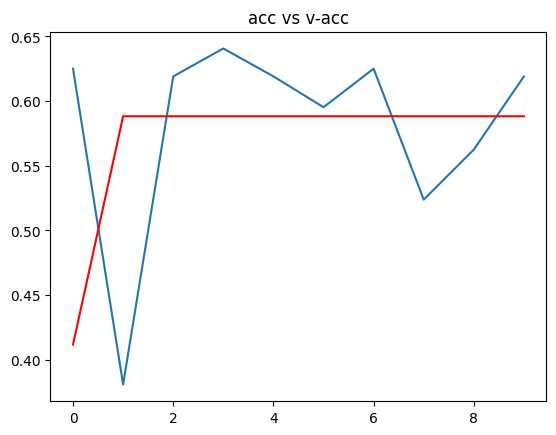

In [ ]:
# Ploting Accuracy In Training Set & Validation Set
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

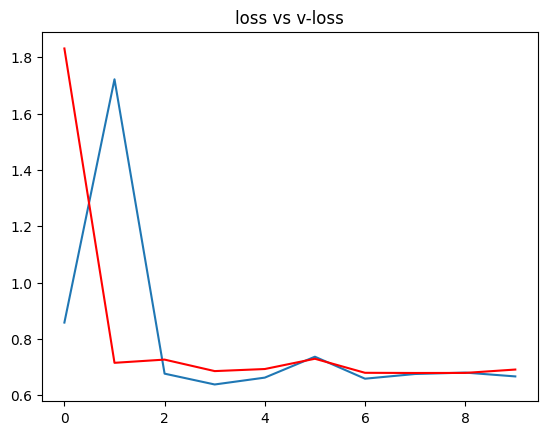

In [ ]:
# Ploting Loss In Training Set & Validation Set
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [ ]:
def cancerPrediction(path):
    # Loading Image
    img = image.load_img(path, target_size=(256,256))
    # Normalizing Image
    norm_img = image.img_to_array(img)/255
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    # Getting Predictions
    pred = (model.predict(input_arr_img) > 0.5).astype(int)[0][0]
    # Printing Model Prediction
    if pred == 0:
        print("Cancer")
    else:
        print("Non-Cancer")

# Path for the image to get predictions
path = "../input/oral-cancer-lips-and-tongue-images/OralCancer/cancer/01960a64-cfe8-444d-bbc5-575c15389a21.jpg"
cancerPrediction(path)

1/1 [==============================] - 0s 75ms/step
Cancer


In [ ]:
cancerPrediction("/content/train/cancer/img_cancer_4.jpg")


1/1 [==============================] - 0s 80ms/step
Cancer
